In [1]:
# IMPORTING LIBRAIRIES
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
from configparser import ConfigParser

from astropy.io import fits
from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy.table import QTable
from astropy import units as u
from astropy.time import Time
from query_eso_archive import query_simbad

from psfao21.psfao21 import psfao21
from psfFitting.psfFitting import psfFitting
import fourier.FourierUtils as FourierUtils

mpl.rcParams['font.size'] = 22
usetex = True
plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})  
path_save = '/home/omartin/Projects/PREDICTION/'

In [5]:
# PARAMETERS FILE
path_ini = '/home/omartin/Projects/P3/parFiles/irdis.ini'
parser = ConfigParser()
parser.optionxform = str
parser.read(path_ini)
fit   = True
xout  = np.zeros(23)

Text(0, 0.5, 'Distance from on-axis [mas]')

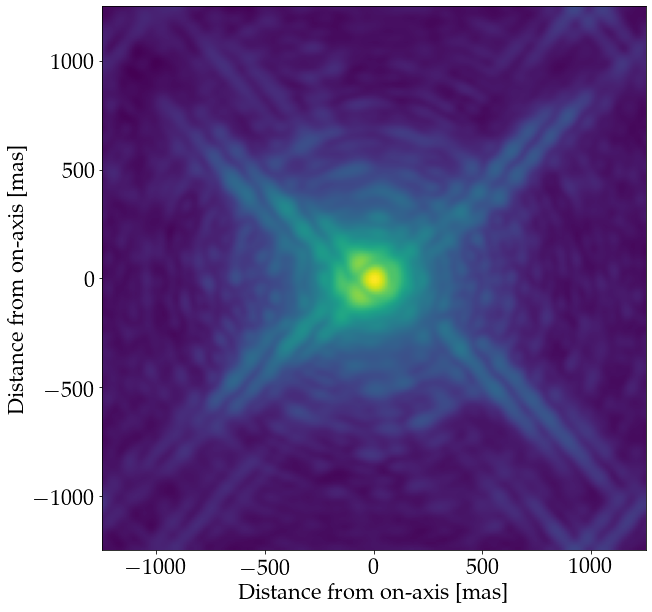

In [60]:
# TESTING THE MODEL
psfao = psfao21(path_ini)
psf   = psfao([0.7,1e-8,1,1e-3,1,0,1.7,0,0,0,1,0,0,0] + xstat)
fov   = 12.5 * psf.shape[0]
xstat = [0,0,0,0,500,100,100,500,0,0,0,0]
plt.figure(figsize=(10,10))
plt.imshow(np.log10(psf),extent=[-fov/2,fov/2,-fov/2,fov/2])
plt.xlabel('Distance from on-axis [mas]')
plt.ylabel('Distance from on-axis [mas]')

In [12]:
names=['YYMMDDHHMMSS','MEAN WAVELENGTH [µm]','BANDWIDTH [µm]','V MAG','R MAG','J MAG','H MAG','K MAG',\
       'tau0 [s]','wDir [deg]','wSpeed [m/s]','RHUM [%]','PRESSURE [?]','FWHM_query [as]','FWHM [as]','FWHMLIN [as]','FWHMLINOBS [as]','SRMIN','SRMAX','SRMEAN',\
       'MIN r0 SPARTA [m]','MAX r0 SPARTA [m]','MEAN r0 SPARTA [m]','MIN WSPEED SPARTA [m/s]','MAX WSPEED SPARTA [m/s]','MEAN WSPEED SPARTA [m/s]','MIN SR SPARTA','MAX SR SPARTA','MEAN SR SPARTA','MIN SEEING SPARTA [as]','MAX SEEING SPARTA [as]','MEAN SEEING SPARTA [as]',\
       'FIT r0 zen 500nm [m]','ERR r0 zen 500nm [m]','FIT C [rad^2]','ERR C [rad^2]','FIT A [rad^2]', 'ERR A [rad^2]','FIT ax [rad^2m^2]', 'ERR ax [rad^2m^2]','FIT p','ERR p', 'FIT theta [deg]','ERR theta [deg]','FIT beta','ERR beta',\
       'FIT FLUX [ADU/DIT]','ERR FLUX [ADU/DIT]','FIT DX [MAS]','ERR DX [MAS]','FIT DY [MAS]','ERR DY [MAS]','FIT BCK [ADU/DIT]','ERR BCK [ADU/DIT]',\
       'FIT PISTON NORTH [nm]', 'ERR PISTON NORTH [nm]', 'FIT PISTON EAST [nm]', 'ERR PISTON EAST [nm]','FIT PISTON SOUTH [nm]', 'ERR PISTON SOUTH [nm]','FIT PISTON WEST [nm]', 'ERR PISTON WEST [nm]',\
       'FIT TIP NORTH [nm]', 'ERR TIP NORTH [nm]', 'FIT TIP EAST [nm]', 'ERR TIP EAST [nm]','FIT TIP SOUTH [nm]', 'ERR TIP SOUTH [nm]','FIT TIP WEST [nm]', 'ERR TIP WEST [nm]',\
       'FIT TILT NORTH [nm]', 'ERR TILT NORTH [nm]', 'FIT TILT EAST [nm]', 'ERR TILT EAST [nm]','FIT TILT SOUTH [nm]', 'ERR TILT SOUTH [nm]','FIT TILT WEST [nm]', 'ERR TILT WEST [nm]',\
       'SR_sky','SR_fit','FWHM_sky','FWHM_fit','FVU','MSE','MAE',\
       'MOON DEC [deg]','MOON RA [deg]','RA [deg]','DEC [deg]','TELAZ [deg]','TELALT [deg]','AIRMASS',\
       'PIXEL SCALE [mas]','gain [e-/ADU]','ron [e-]','DIT [s]','NDIT','NDSKIP','TEMP AMBI [C]','TEMP M1 [C]']
TEMP = ['TEMP10'+str(s)+' [C]' for s in range(1,6)]
TEMP = TEMP+['TEMP4'+str(s).zfill(2)+' [C]' for s in range(3,56)]
names= names + TEMP        

In [4]:
def processData(im,nPix):
    nF    = im.shape[0]
    out   = np.zeros((nF,nPix,nPix))
    for kf in range(nF):
        tmp     = im[kf]
        x0,y0   = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
        out[kf] = tmp[x0-nPix//2:x0+nPix//2,y0-nPix//2:y0+nPix//2]
    # stacking 
    out = np.mean(out,axis=0)
    # normalizing
    DIT=1
    ND =1
    out = out/DIT/ND
    return out

In [22]:
# LOOP ON DATA FOLDER
Tab = QTable(names=names)
path_data = '/home/omartin/Projects/PREDICTION/CODES/SPHERE_DC_DATA/'
listDir   = os.listdir(path_data)
nDir      = len(listDir)
for jDir in [1]:
    path_data_j   = path_data + listDir[jDir] +'/'
    listFolder    = os.listdir(path_data_j)
    nFolder       = len(listFolder)
    for kFolder in range(1):
        path_data_j_k = path_data_j + listFolder[kFolder] +'/'
        listFiles     = os.listdir(path_data_j_k)
        
        # ---------------------------- LOADING DATA
        # GETTING WAVELENGTHS
        wvl = 1e-6*fits.getdata(path_data_j_k + 'ird_convert_recenter_dc5-IRD_SCIENCE_LAMBDA_INFO-lam.fits')
        nWvl= len(wvl)
        bw  = wvl.max() - wvl.min()
        wvl = wvl.mean()
        # GETTING SPARTA DATA
        r0_sparta = [-1,-1,-1]
        v_sparta = [-1,-1,-1]
        SR_sparta = [-1,-1,-1]
        seeing_sparta = [-1,-1,-1]
        sparta = fits.getdata(path_data_j_k + 'ird_convert_recenter_dc5-SPH_SPARTA_PSFDATA-psf_sparta_data.fits')
        #psf_sparta_data.fits: ​sparta information at the time of the PSF observations. 
        #if npsfPSF files exists, this is a [3, npsf+1,4] array
        #○    dim 1 : r0, wind, strehl ratio, seeing 
        #○    dim 2 : 0: npsf-1 : for each PSF file.   Last line = stat combining all frames of allfiles
        #○    dim 3 : min, max, avg
        #Reminder:  The SPARTA Strehl ratio is provided at 1.6 micron and the turbulence parameters (r0, seeing) at 500nm.
        r0_sparta     = list(sparta[0,-2,:])
        v_sparta      = list(sparta[1,-2,:])
        SR_sparta     = list(sparta[2,-2,:])
        seeing_sparta = list(sparta[3,-2,:])
        nPSF          = sparta.shape[1]-1 # number of acquisitions during the observation
        # note : nPSF must == nFiles/2 with raw images or im.shape[0]//2 with processed images
        
        # RAW FRAMES ARE AVAILABLE
        if path.exists(path_data_j_k + 'inputs/'): 
            nPix = 200
            path_data_j_k_n = path_data_j_k + 'inputs/'
            listRaw         = np.sort(os.listdir(path_data_j_k_n))
            nFiles          = len(listRaw)
            im              = np.zeros((2,nPSF,nPix,nPix))           
            for n in [nPSF-1]: # taking the latest left/right images
                # GETTING HEADER
                hdr     = fits.getheader(path_data_j_k_n + listRaw[2*n])
                # GETTING LEFT IMAGE
                tmp     = fits.getdata(path_data_j_k_n + listRaw[2*n])
                im[0,n] = processData(tmp,nPix) 
                # GETTING RIGHT IMAGE
                tmp     = fits.getdata(path_data_j_k_n + listRaw[2*n+1])
                im[1,n] = processData(tmp,nPix) 
                # in this format, if nPix=64, we should retrieve the PSF_MASTER_CUBE PSF
                hdr     = fits.getheader(path_data_j_k + 'ird_convert_recenter_dc5-IRD_SCIENCE_PSF_MASTER_CUBE-median_unsat.fits') 
                SRMEAN  = float(hdr['SRMEAN'])         
                SRMIN   = float(hdr['SRMIN'])                                
                SRMAX   = float(hdr['SRMAX'])
                flux    = float(hdr['DATASUM'])
        # RAW FRAMES ARE NOT AVAILABLE
        else:
            path_fits = path_data_j_k + 'ird_convert_recenter_dc5-IRD_SCIENCE_PSF_MASTER_CUBE-median_unsat.fits'
            #GETTING HEADER
            hdr  = fits.getheader(path_fits)
            # GETTING IMAGES
            im   = fits.getdata(path_fits)
            nPix = im.shape[1]
            SRMEAN    = float(hdr['SRMEAN'])         
            SRMIN     = float(hdr['SRMIN'])                                
            SRMAX     = float(hdr['SRMAX'])          
            flux      = float(hdr['DATASUM'])
        # Average over the spectral slice and taking the latest data
        im2 = np.median(im,axis=0)[-1]
        
        #UPDATING THE OUTPUT TABLE
        # data ID
        DATE_OBS  = hdr['DATE-OBS']
        DATE_OBS  = DATE_OBS[0:4]+DATE_OBS[5:7]+DATE_OBS[8:10]+DATE_OBS[11:13]+DATE_OBS[14:16]+DATE_OBS[17:19]
        #TARG_NAME = hdr['ESO OBS TARG NAME']
        #FILT_NAME = hdr['ESO INS COMB IFLT']
        OB_NAME   = hdr['ESO OBS NAME']
        MOON_DEC  = hdr['ESO TEL MOON DEC']
        MOON_RA   = hdr['ESO TEL MOON RA']
        #ICOR      = hdr['ESO INS COMB ICOR']
        # telescope orientation
        RA        = float(hdr['RA'])
        DEC       = float(hdr['DEC'])
        TELAZ     = float(hdr['ESO TEL AZ'])
        TELALT    = float(hdr['ESO TEL AZ'])
        airmass   = 0.5*(float(hdr['ESO TEL AIRM END']) + float(hdr['ESO TEL AIRM START']))     
        # STAR
        DICT_SIMBAD= query_simbad(Time(hdr['DATE-OBS']),SkyCoord(RA*u.degree,DEC*u.degree),name=OB_NAME)
        VMAG = RMAG = JMAG = HMAG = KMAG = -1
        if 'simbad_FLUX_V' in DICT_SIMBAD:
            VMAG = DICT_SIMBAD['simbad_FLUX_V']
        if 'simbad_FLUX_R' in DICT_SIMBAD:
            RMAG = DICT_SIMBAD['simbad_FLUX_R']
        if 'simbad_FLUX_J' in DICT_SIMBAD:
            JMAG = DICT_SIMBAD['simbad_FLUX_J']
        if 'simbad_FLUX_H' in DICT_SIMBAD:
            HMAG = DICT_SIMBAD['simbad_FLUX_H']
        if 'simbad_FLUX_K' in DICT_SIMBAD:
            KMAG = DICT_SIMBAD['simbad_FLUX_K']
        # detector
        psInMas   = float(hdr['PIXSCAL'])
        gain      = float(hdr['ESO DET CHIP1 GAIN'])
        ron       = float(hdr['ESO DET CHIP1 RON'])
        DIT       = hdr['ESO DET SEQ1 REALDIT']
        NDIT      = hdr['ESO DET NDIT']
        NDSKIP    = hdr['ESO DET NDSKIP']  
        im        = im/((NDIT-NDSKIP)*DIT)

        # temperature sensors
        TEMP = np.zeros(1+1 + 5 + 53)
        TEMP[0] = float(hdr['ESO TEL AMBI TEMP'])
        TEMP[1] = float(hdr['ESO TEL TH M1 TEMP'])
        for t in range(1,6):
            TEMP[t+2]   = float(hdr['ESO INS1 TEMP10'+str(t)+' VAL'])       
        INS = 0
        for iii in range(4):
            if 'ESO INS'+str(iii+1)+' TEMP401 ID' in hdr:
                INS = int(iii+1)
        if INS>0:
            for t in range(3,53):
                if t<12 or t>51:
                    dd = -273 # from Kelvin to degrees Celsius
                else:
                    dd = 0
                TEMP[t+7]   = float(hdr['ESO INS'+str(INS)+' TEMP4'+str(t+3).zfill(2)+' VAL']) + dd       
        # atmospheric parameters
        tau0      = float(hdr['ESO TEL AMBI TAU0'])
        wDir      = float(hdr['ESO TEL AMBI WINDDIR'])
        wSpeed    = float(hdr['ESO TEL AMBI WINDSP'])
        RHUM      = float(hdr['ESO TEL AMBI RHUM'])
        pressure  = 0.5*(float(hdr['ESO TEL AMBI PRES START']) + float(hdr['ESO TEL AMBI PRES END']))
        FWHM_query= 0.5*(float(hdr['ESO TEL AMBI FWHM START']) + float(hdr['ESO TEL AMBI FWHM END']))
        FWHM      = float(hdr['ESO TEL IA FWHM'])
        FWHMLIN   = float(hdr['ESO TEL IA FWHMLIN'])
        FWHMLINOBS= float(hdr['ESO TEL IA FWHMLINOBS'])
        seeing_los= FWHM * airmass**(3/5)
                         

        if fit:
            #UPDATING PARAMETERS
            parser.set('atmosphere','seeing',str(seeing_los))
            parser.set('PSF_DIRECTIONS','ScienceWavelength',str([wvl]))
            parser.set('PSF_DIRECTIONS','psf_FoV',str(nPix))
            with open(path_ini, 'w') as configfile:
                parser.write(configfile)
            
            # INSTANTIATING THE PSF MODEL
            psfao = psfao21(path_ini)
        
            # FITTING THE IMAGE
            if nPix >= 2*int(1.5*psfao.kc_*wvl*1e-6*206264.8*1e3/psInMas//2):
                fixed = (False,False,False,False,False,False,False,True,True,True,False,False,False,False,) + (False,)*12
            else:
                fixed = (True,False,False,False,False,False,False,True,True,True,False,False,False,False) + (False,)*12
                
            r053  = airmass * psfao.atm.r0**(-5/3) * (psfao.atm.wvl/wvl)**2
            x0    = [r053,1e-4,0.3,1e-2,1,0,1.7,0,0,0,np.sum(im2),0,0,0] + list(np.zeros(12))
            weights = np.zeros_like(im2)
            weights[im2>0] = im2[im2>0]
            weights = 1.0/(weights + 5**2)
            res   = psfFitting(im2,psfao,x0,fixed=fixed,method='trf',verbose=0,weights=weights)
            # unpacking parameters
            r0_fit= res.x[0]**(-3/5) * (500e-9/wvl)**1.2 * airmass**(3/5)
            C_fit = res.x[1];A_fit = res.x[2];ax_fit= res.x[3];p_fit = res.x[4];theta_fit = res.x[5];beta_fit= res.x[6]
            F_fit = res.x[10];dx_fit=res.x[11]*psfao.psInMas;dy_fit=res.x[12]*psfao.psInMas;bkg_fit = res.x[13];
            pist_north_fit = res.x[14];pist_east_fit = res.x[15];pist_south_fit = res.x[16];pist_west_fit= res.x[17];
            tip_north_fit = res.x[18];tip_east_fit = res.x[19];tip_south_fit = res.x[20];tip_west_fit= res.x[21];
            tilt_north_fit = res.x[22];tilt_east_fit = res.x[23];tilt_south_fit = res.x[24];tilt_west_fit= res.x[25];
            #unpacking 95% confidence interval error
            r0_err= 3/5*res.x[0]**(-8/5)*res.xerr[0] * (500e-9/wvl)**1.2 * airmass**(3/5)
            C_err = res.xerr[1];A_err = res.xerr[2];ax_err= res.xerr[3];p_err = res.xerr[4];theta_err = res.xerr[5];beta_err= res.xerr[6]
            F_err = res.xerr[10];dx_err=res.xerr[11]*psfao.psInMas;dy_err=res.xerr[12]*psfao.psInMas;bkg_err = res.xerr[13];
            pist_north_err = res.xerr[14];pist_east_err = res.xerr[15];pist_south_err = res.xerr[16];pist_west_err= res.xerr[17];
            tip_north_err = res.xerr[18];tip_east_err = res.xerr[19];tip_south_err = res.xerr[20];tip_west_err= res.xerr[21];
            tilt_north_err = res.xerr[22];tilt_east_err = res.xerr[23];tilt_south_err = res.xerr[24];tilt_west_err= res.xerr[25];
        else:
            r0_fit= C_fit = A_fit = ax_fit= p_fit = theta_fit = beta_fit= F_fit = dx_fit = dy_fit=bkg_fit=-1
            F_fit = dx_fit=dy_fit=bkg_fit= pist_north_fit = pist_east_fit = pist_south_fit = pist_west_fit =-1
            tip_north_fit = tip_east_fit = tip_south_fit = tip_west_fit = tilt_north_fit = tilt_east_fit = tilt_south_fit = tilt_west_fit =-1
            
            r0_err= C_err = A_err = ax_err= p_err = theta_err = beta_err= F_err = dx_err = dy_err=bkg_err=-1
            F_err = dx_err=dy_err=bkg_err= pist_north_err = pist_east_err = pist_south_err = pist_west_err =-1
            tip_north_err = tip_east_err = tip_south_err = tip_west_err = tilt_north_err = tilt_east_err = tilt_south_err = tilt_west_err =-1
            
            
        #UPDATING THE OUTPUT TABLE
       # names=['YYMMDDHHMMSS','MEAN WAVELENGTH [µm]','BANDWIDTH [µm]','V MAG','R MAG','J MAG','H MAG','K MAG',\
       #'tau0 [s]','wDir [deg]','wSpeed [m/s]','RHUM [%]','PRESSURE [?]','FWHM_query [as]','FWHM [as]','FWHMLIN [as]','FWHMLINOBS [as]','SRMIN','SRMAX','SRMEAN',\
       #'MIN r0 SPARTA [m]','MAX r0 SPARTA [m]','MEAN r0 SPARTA [m]','MIN WSPEED SPARTA [m/s]','MAX WSPEED SPARTA [m/s]','MEAN WSPEED SPARTA [m/s]','MIN SR SPARTA','MAX SR SPARTA','MEAN SR SPARTA','MIN SEEING SPARTA [as]','MAX SEEING SPARTA [as]','MEAN SEEING SPARTA [as]',\
       #'FIT r0 zen 500nm [m]','ERR r0 zen 500nm [m]','FIT C [rad^2]','ERR C [rad^2]','FIT A [rad^2]', 'ERR A [rad^2]','FIT ax [rad^2m^2]', 'ERR ax [rad^2m^2]','FIT p','ERR p', 'FIT theta [deg]','ERR theta [deg]','FIT beta','ERR beta',\
       #'FIT FLUX [ADU/DIT]','ERR FLUX [ADU/DIT]','FIT DX [MAS]','ERR DX [MAS]','FIT DY [MAS]','ERR DY [MAS]','FIT BCK [ADU/DIT]','ERR BCK [ADU/DIT]',\
       #'FIT PISTON NORTH [nm]', 'ERR PISTON NORTH [nm]', 'FIT PISTON EAST [nm]', 'ERR PISTON EAST [nm]','FIT PISTON SOUTH [nm]', 'ERR PISTON SOUTH [nm]','FIT PISTON WEST [nm]', 'ERR PISTON WEST [nm]',\
       #'FIT TIP NORTH [nm]', 'ERR TIP NORTH [nm]', 'FIT TIP EAST [nm]', 'ERR TIP EAST [nm]','FIT TIP SOUTH [nm]', 'ERR TIP SOUTH [nm]','FIT TIP WEST [nm]', 'ERR TIP WEST [nm]',\
       #'FIT TILT NORTH [nm]', 'ERR TILT NORTH [nm]', 'FIT TILT EAST [nm]', 'ERR TILT EAST [nm]','FIT TILT SOUTH [nm]', 'ERR TILT SOUTH [nm]','FIT TILT WEST [nm]', 'ERR TILT WEST [nm]',\
       #'SR_sky','SR_fit','FWHM_sky','FWHM_fit','FVU','MSE','MAE',\
       #'MOON DEC [deg]','MOON RA [deg]','RA [deg]','DEC [deg]','TELAZ [deg]','TELALT [deg]','AIRMASS',\
       #'PIXEL SCALE [mas]','gain [e-/ADU]','ron [e-]','DIT [s]','NDIT','NDSKIP','TEMP AMBI [C]','TEMP M1 [C]']
       # TEMP = ['TEMP10'+str(s)+' [C]' for s in range(1,6)]
       # TEMP = TEMP+['TEMP4'+str(s).zfill(2)+' [C]' for s in range(3,56)]

        data = (DATE_OBS,wvl*1e6,bw*1e6,VMAG,RMAG,JMAG,HMAG,KMAG,\
                tau0,wDir,wSpeed,RHUM,pressure,FWHM_query,FWHM,FWHMLIN,FWHMLINOBS,SRMIN,SRMAX,SRMEAN,\
                r0_sparta[0],r0_sparta[1],r0_sparta[2],v_sparta[0],v_sparta[1],v_sparta[2],SR_sparta[0],SR_sparta[1],SR_sparta[2],seeing_sparta[0],seeing_sparta[1],seeing_sparta[2],\
                r0_fit,r0_err,C_fit,C_err,A_fit,A_err,ax_fit,ax_err,p_fit,p_err,theta_fit,theta_err,beta_fit,beta_err,\
                F_fit,F_err,dx_fit,dx_err,dy_fit,dy_err,bkg_fit,bkg_err,\
                pist_north_fit,pist_north_err,pist_east_fit,pist_east_err,pist_south_fit,pist_south_err,pist_west_fit,pist_west_err,\
                tip_north_fit,tip_north_err,tip_east_fit,tip_east_err,tip_south_fit,tip_south_err,tip_west_fit,tip_west_err,\
                tilt_north_fit,tilt_north_err,tilt_east_fit,tilt_east_err,tilt_south_fit,tilt_south_err,tilt_west_fit,tilt_west_err,\
                res.SR_sky,res.SR_fit,0.5*(res.FWHMx_sky+res.FWHMy_sky),0.5*(res.FWHMx_fit+res.FWHMy_fit),res.fvu,res.mse,res.mae,\
                MOON_DEC,MOON_RA,RA,DEC,TELAZ,TELALT,airmass,\
                psInMas,gain,ron,DIT,NDIT,NDSKIP)
        data += tuple(TEMP)
        # in psfao: add static aberrations + uncertainty on parameters
        Tab.add_row(data)
        #Tab.write(path_save+'irdis_data.csv',overwrite=True)

One star found: HD  13246 with V=7.5
Distance between the current star position and pointing position: 1.2arcsec
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[ 2.06424664e+00  1.25089628e-03  3.60048026e-01  1.49011612e-08
  9.57985186e-01 -2.69666143e-01  1.68879775e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.79558497e+07 -1.96055846e-02
 -7.65146754e-02 -1.23794510e+02 -2.12349210e+03 -2.11505481e+03
 -1.09025000e-06  1.09025000e-06 -1.09025000e-06 -1.09025000e-06
 -1.09025000e-06  1.09025000e-06 -1.09025000e-06  1.09025000e-06
 -1.09025000e-06  1.09025000e-06]
[3.2, 0.0, 0.3, 0.0, 1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 25392107.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2.1, 0.0, 0.4, 0.0, 1.0, -0.3, 1.7, 0.0, 0.0, 0.0, 27955849.7, -0.0, -0.1, -123.8, -2123.5, -2115.1, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0]
[-1.0, -1.0, -1.0]
0.09575500029431014
0.09782260754162193


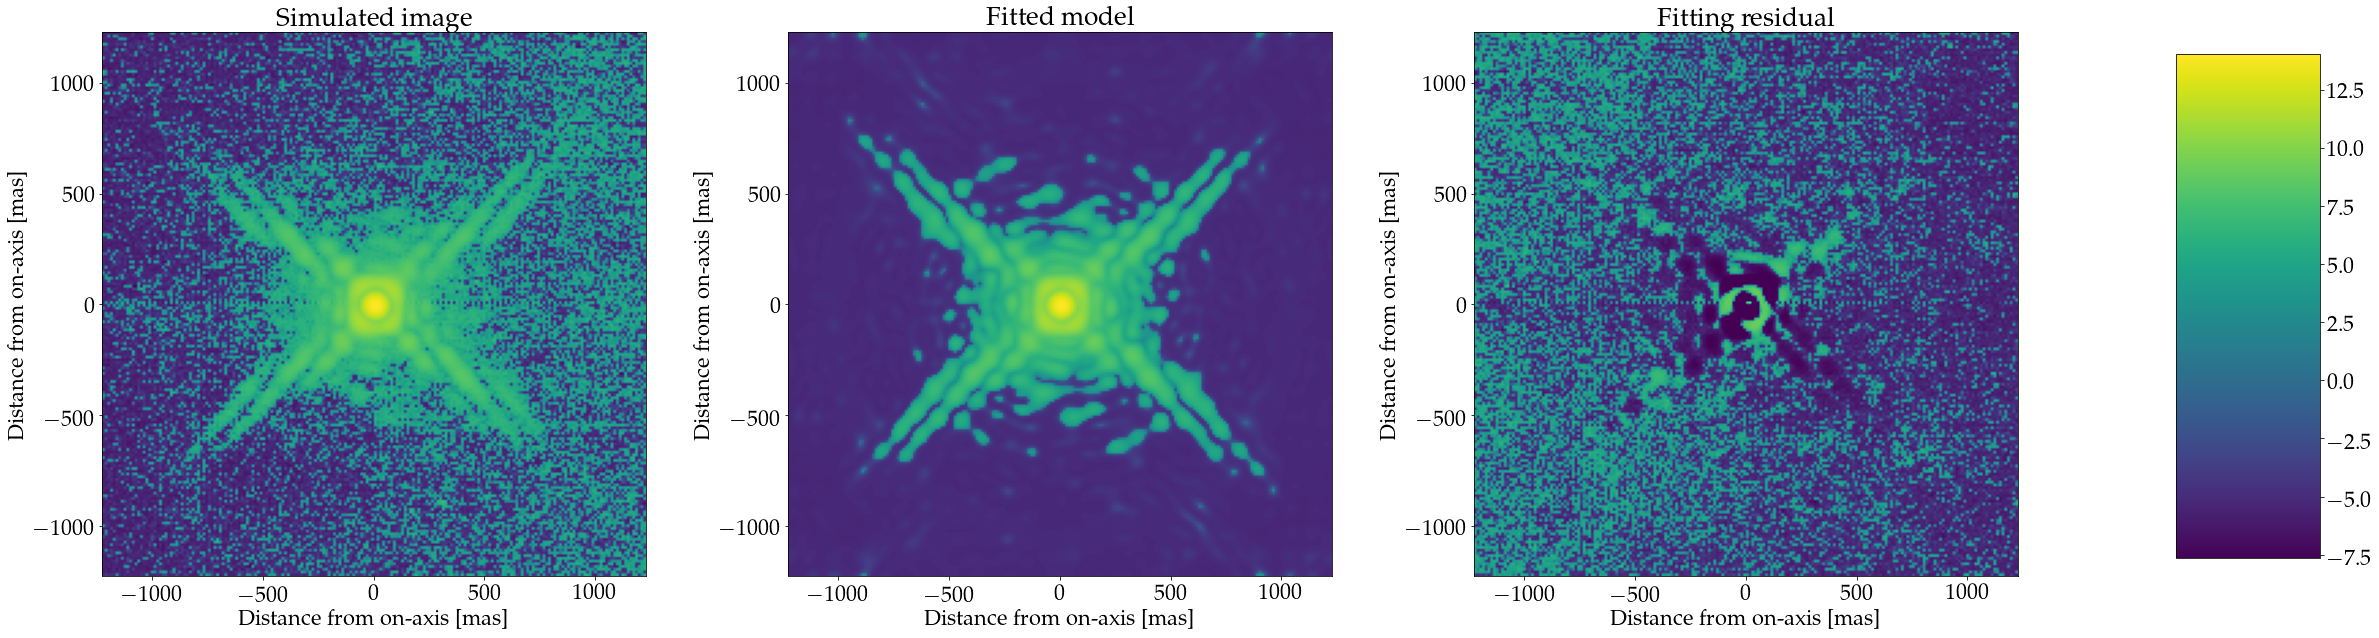

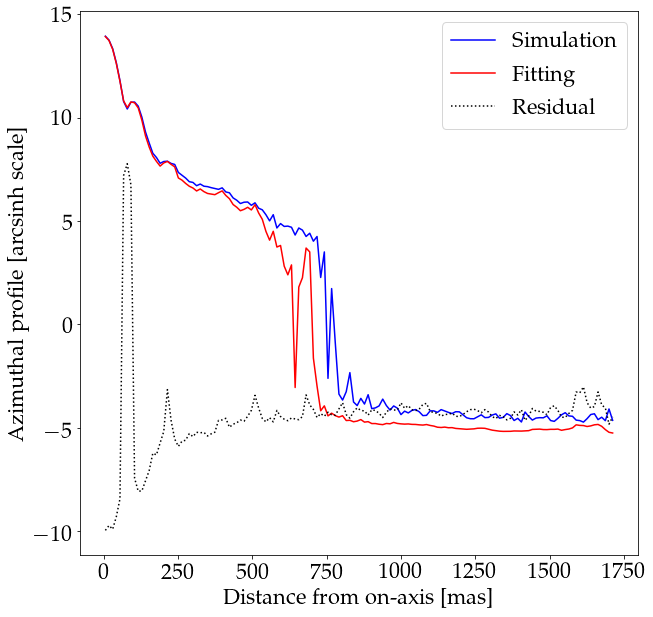

In [23]:
print(res.x)
fov  = nPix*psInMas
vmin = np.arcsinh(res.im_sky).min()
vmax = np.arcsinh(res.im_sky).max()

plt.close('all')
fig, axs = plt.subplots(1,3,figsize=(40,10))
axs[0].imshow(np.arcsinh(res.im_sky),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[0].set_xlabel('Distance from on-axis [mas]')
axs[0].set_ylabel('Distance from on-axis [mas]')
axs[0].set_title('Simulated image')

axs[1].imshow(np.arcsinh(res.im_fit),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[1].set_xlabel('Distance from on-axis [mas]')
axs[1].set_ylabel('Distance from on-axis [mas]')
axs[1].set_title('Fitted model')

pcm=axs[2].imshow(np.arcsinh((res.im_fit - res.im_sky)),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[2].set_xlabel('Distance from on-axis [mas]')
axs[2].set_ylabel('Distance from on-axis [mas]')
axs[2].set_title('Fitting residual')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax=cbar_ax)

x , prof_sky = FourierUtils.radial_profile(res.im_sky)
x = x*psInMas
plt.figure(figsize=(10,10))
plt.plot(x,np.arcsinh(prof_sky),'b',label='Simulation')
plt.plot(x,np.arcsinh(FourierUtils.radial_profile(res.im_fit,nargout=1)),'r',label='Fitting')
plt.plot(x,np.arcsinh(FourierUtils.radial_profile((res.im_fit - res.im_sky),nargout=1)),'k:',label='Residual')
plt.legend()
plt.xlabel('Distance from on-axis [mas]')
plt.ylabel('Azimuthal profile [arcsinh scale]')

print(list(np.around(res.xinit,1)))
print(list(np.around(res.x,1)))
print(r0_sparta)
print(206264.8*0.976*500e-9/seeing_los)
print(res.x[0]**(-3/5) * (500e-9/wvl)**1.2 * airmass**(-3/5))


In [24]:
res

   FWHMx_fit: 64.35412910529234
   FWHMx_sky: 64.72234527000671
   FWHMy_fit: 62.98278537534904
   FWHMy_sky: 62.95015173080634
      SR_fit: 0.79
      SR_sky: 0.82
 active_mask: array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1, -1, -1,
       -1,  1, -1,  1, -1,  1])
        cost: 4014533.013026164
         fun: array([ 10.04866212,  -1.7471431 ,  10.88225305, ...,  -3.87568132,
       -18.98200111, -18.59538131])
         fvu: 0.060942699090300534
        grad: array([ 4.42635785e-03,  1.83011917e+01,  1.63508413e-01,  4.43536671e-01,
       -9.68473033e-01,  6.09802838e-01, -1.08601314e+01, -1.12272124e-06,
       -2.09193800e+00, -7.07707508e+00,  6.06422598e-04,  1.17431092e-01,
       -1.40572255e-01,  5.42097126e+00, -8.25444326e+00,  7.22038356e+01,
        4.36921243e+00,  9.13994277e+01, -1.45539996e+01,  1.85979067e+01,
       -6.23227747e+01,  5.02982119e+00, -4.42524330e+01])
      im_fit: array([[-92.21663761, -93.40419293, -96.15549368, ..., -96.0584302

In [25]:
im2   = fits.getdata(path_data_j_k + 'ird_convert_recenter_dc5-IRD_SCIENCE_PSF_MASTER_CUBE-median_unsat.fits') 
plt.figure(figsize=(10,10))
plt.imshow(np.arcsinh(np.concatenate((im2[0,1],im[0,1],im[0,1]-im2[0,1]),axis=1)))
plt.figure()
plt.plot(im2[0,1].reshape(-1),im[0,1].reshape(-1),'bs')
plt.plot([0,im2[0,1].max()],[0,im2[0,1].max()],'k')

ValueError: operands could not be broadcast together with shapes (200,200) (64,64) 

<Figure size 720x720 with 0 Axes>

Text(0, 0.5, 'Azimuthal profile [arcsinh scale]')

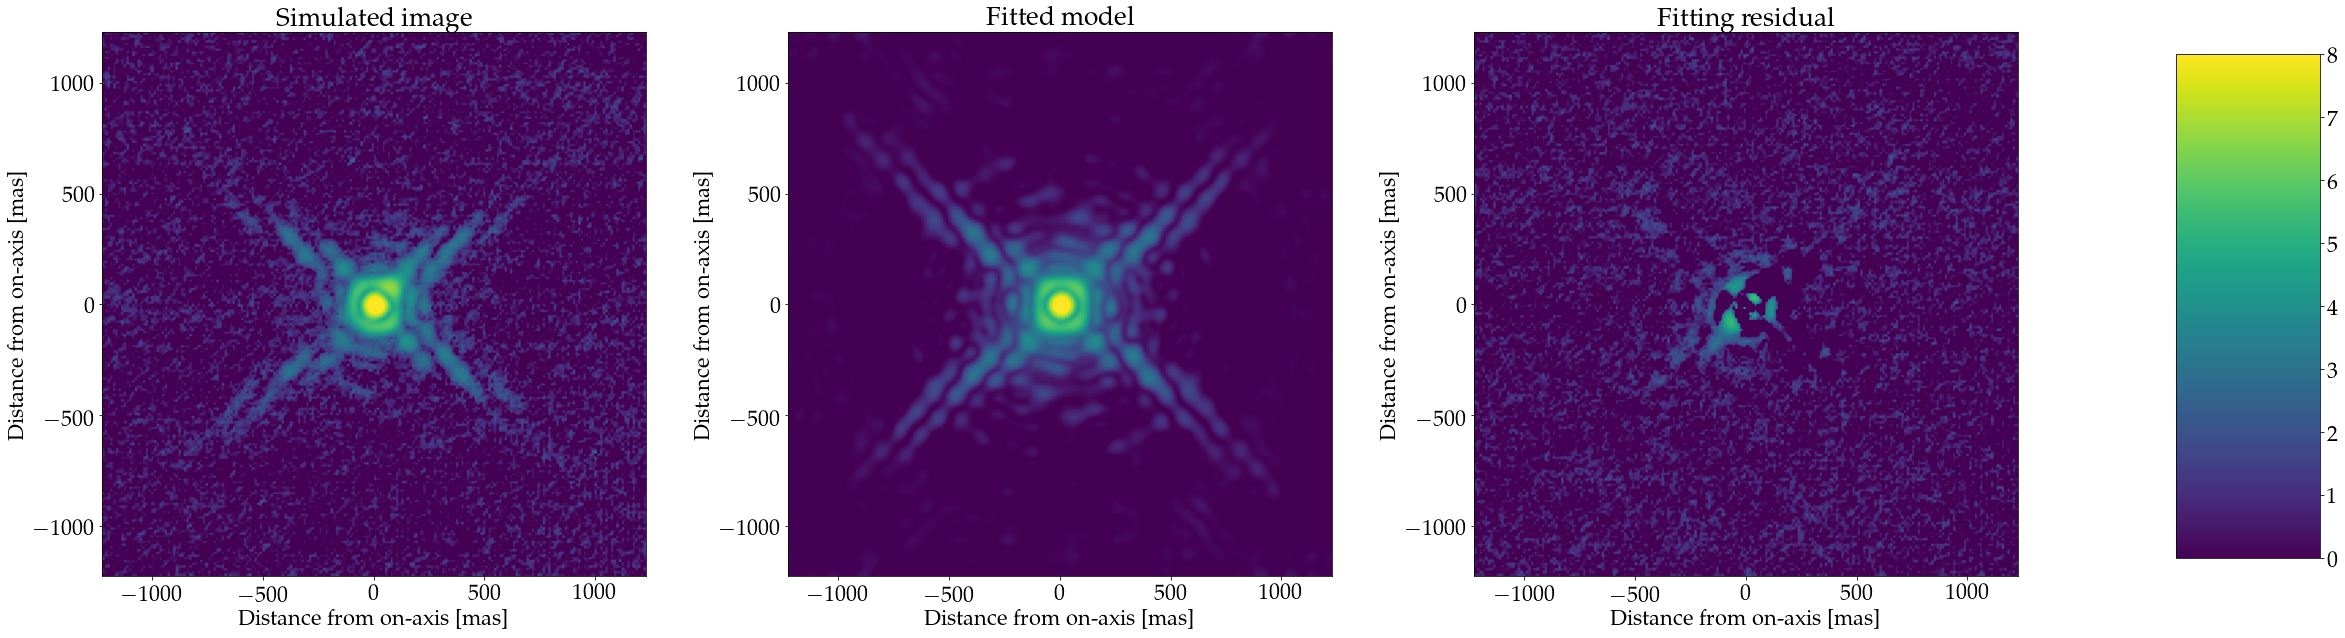

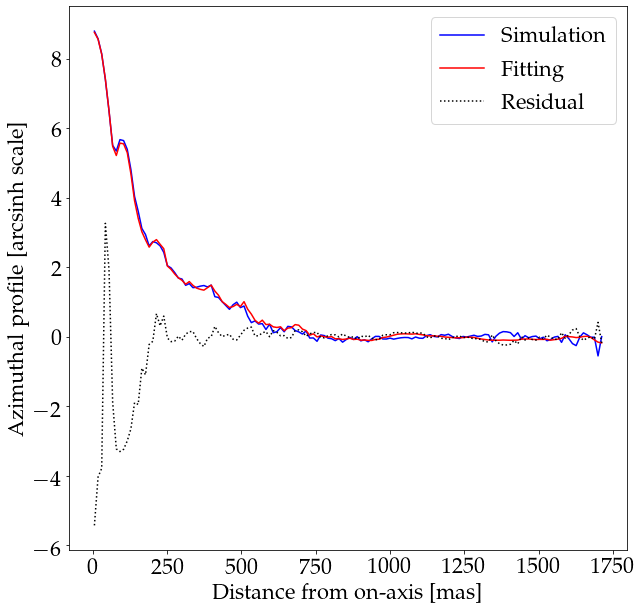

[2.9, 0.0, 0.3, 0.0, 1.0, 0.0, 1.3, 0.0, 0.0, 0.0, 145277.7, 0.0, 0.0, 0.0]
[3.3, 0.0, 0.3, 0.0, 1.1, 144834.3, 1.6, 0.0, 0.0, 0.0, 155359.9, 0.0, -0.1, -0.3]
-1.0
0.10507142373920639
0.07247670790600273
